# Análisis de sensibilidad: distintas clases de activos frente a la fortaleza del dólar

La idea es analizar la sensibilidad de varios activos a la fortaleza del dollar.<br> Este notebook corresponde al artículo  http://estrategiastrading.com/etfs-frente-al-dolar/
## 1. Cargar paquetes y datos

In [1]:
# Importo paquetes y configuración
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import statsmodels.api as sm
# configuración gráficos
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize']= 16,8
plt.style.use('seaborn-darkgrid')
#parche Yahoo
import fix_yahoo_finance as yf
yf.pdr_override()

In [2]:
#cargo datos
symbols= ['UUP','SPY','IWM','QQQ','EFA','EEM','VEU',
          'VGK','AGG','TLT','USO','DBA','GLD','DBC','VNQ']
start = "2008-10-01" 
end = "2018-11-01"

ETFs= pd.DataFrame()
for sym in symbols:
    ETFs[sym] = pdr.get_data_yahoo(sym, start, end) ['Adj Close']

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

In [3]:
#guardo copia de la data
ETFs.to_csv('datos_ETFs_Dollar_impact_version2.csv')

In [4]:
"""Convierto a datos a retornos mensuales
baja el ruido"""
ETFm = ETFs.resample('M').last()

## 2. Rentabilidades

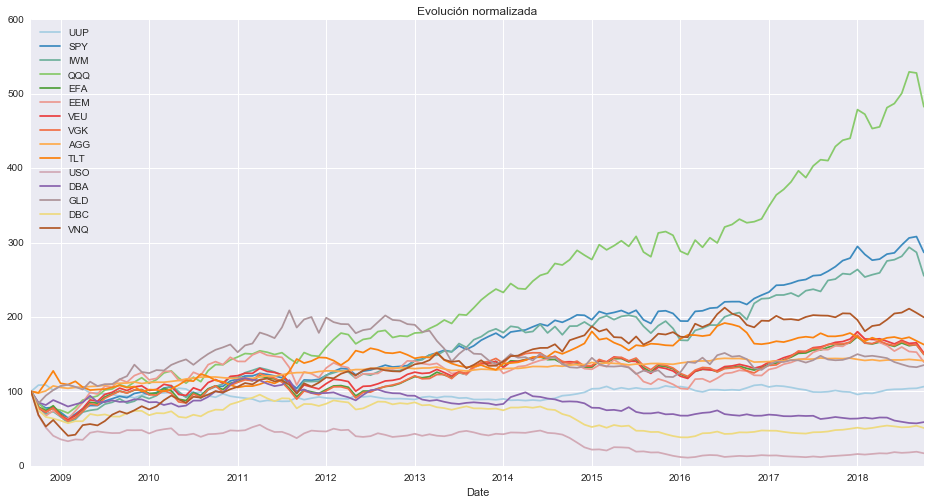

In [5]:
ax= (ETFm / ETFm.iloc[0] * 100).plot(colormap='Paired')
plt.title ('Evolución normalizada');

In [6]:
# Rendimientos mensuales
dfm_returns = np.log(ETFm).diff().dropna()

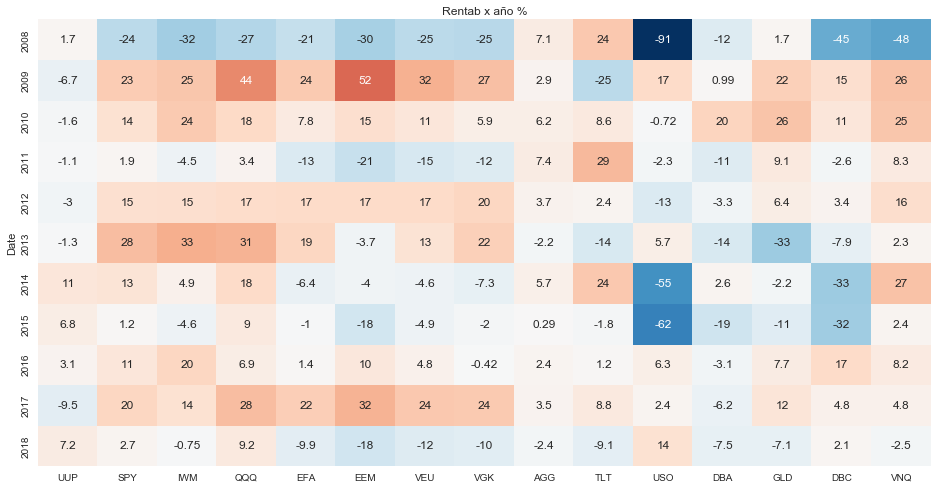

In [7]:
df_plot =(dfm_returns.resample('A').sum()).multiply(100).round(2)
df_plot.index = df_plot.index.map(lambda t: t.strftime('%Y'))
sns.heatmap(df_plot,annot =True,cbar=False,center=0)
plt.title('Rentab x año %');
#recordar que 2008 está sólo a partir de octubre

## 3. Correlaciones

Primero miramos las correlaciones de los activos con el dólar (ETF UUP)

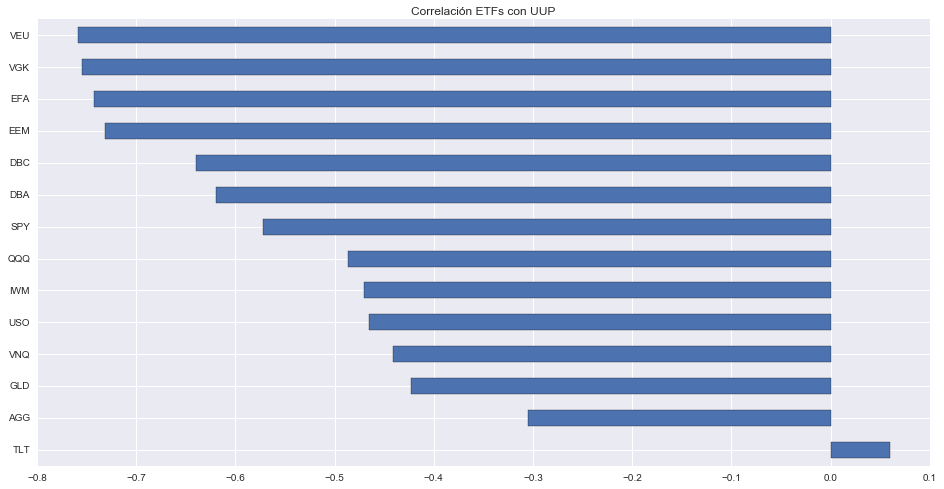

In [8]:
correlation = dfm_returns.corrwith(dfm_returns['UUP'])
correlation.sort_values(ascending=False).drop('UUP').plot.barh()
plt.title('Correlación ETFs con UUP');

Como era casi de esperar, las correlaciones son negativas especialmente en los ETFs que replican la renta variable no US.

## 4. Cálculo sensibilidad

La Beta de una acción nos indica la sensibilidad de dicha acción respecto a los movimientos del mercado. Aquí lo que se hace es aplicar la beta pero en vez de utilizar el mercado utilizamos el ETF que replica el dolar.

In [9]:
# Calculo Beta
cov = dfm_returns.cov()['UUP']
var = dfm_returns['UUP'].var()
Beta = cov /var

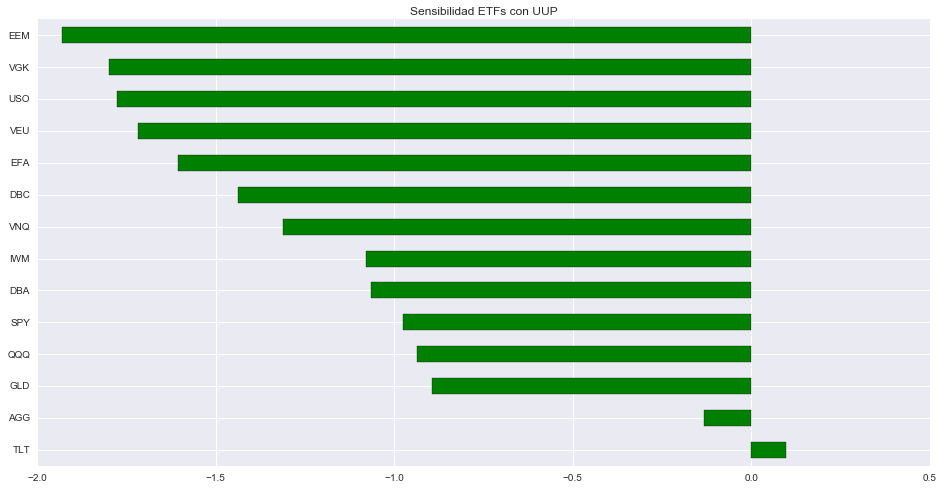

In [10]:
Beta.sort_values(ascending=False).drop('UUP').plot.barh(color="green")
plt.title('Sensibilidad ETFs con UUP');

In [11]:
#Calculo Alpha
alfa= np.mean(dfm_returns)-Beta*np.mean(dfm_returns['UUP'])
alfa

UUP    0.000000
SPY    0.009212
IWM    0.008307
QQQ    0.013492
EFA    0.004165
EEM    0.003741
VEU    0.004326
VGK    0.004267
AGG    0.002923
TLT    0.003985
USO   -0.013816
DBA   -0.003848
GLD    0.002965
DBC   -0.004848
VNQ    0.006389
dtype: float64

---
***¿Qué tan bien se ajustan esas líneas de regresión?***<br>
Cuando el coeficiente r de Pearson se eleva al cuadrado, el resultado indica el porcentaje de la variación de una variable debido a la variación de la otra y viceversa. Es decir, el coeficiente de determinación, r al cuadrado o r², es la proporción de la variación en Y explicada por X. Puede adoptar cualquier valor entre 0 y 1


In [12]:
result = pd.DataFrame({'Alpha': alfa,'Correlation': correlation,'Beta':Beta})
result['Coef_det']= result['Correlation'] ** 2
result

,Alpha,Beta,Correlation,Coef_det
UUP,0.000000,1.000000,1.000000,1.000000
SPY,0.009212,-0.975671,-0.572411,0.327654
IWM,0.008307,-1.079796,-0.470361,0.221240
QQQ,0.013492,-0.935383,-0.486416,0.236600
EFA,0.004165,-1.605708,-0.742190,0.550846
EEM,0.003741,-1.930605,-0.731151,0.534582
VEU,0.004326,-1.716052,-0.758803,0.575782
VGK,0.004267,-1.797680,-0.754874,0.569834
AGG,0.002923,-0.133117,-0.304816,0.092912
TLT,0.003985,0.097986,0.059351,0.003523


Correlación al cuadrado = coef determinación
Tenemos coeficientes de determinación bastante bajos

In [13]:
# Test con s.ols para ver si R2 es =
x = dfm_returns['UUP']
y = dfm_returns['EEM']
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    EEM   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     136.5
Date:                Thu, 08 Nov 2018   Prob (F-statistic):           1.60e-21
Time:                        11:22:56   Log-Likelihood:                 204.25
No. Observations:                 121   AIC:                            -406.5
Df Residuals:                     120   BIC:                            -403.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
UUP           -1.9274      0.165    -11.683      0.0

---

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


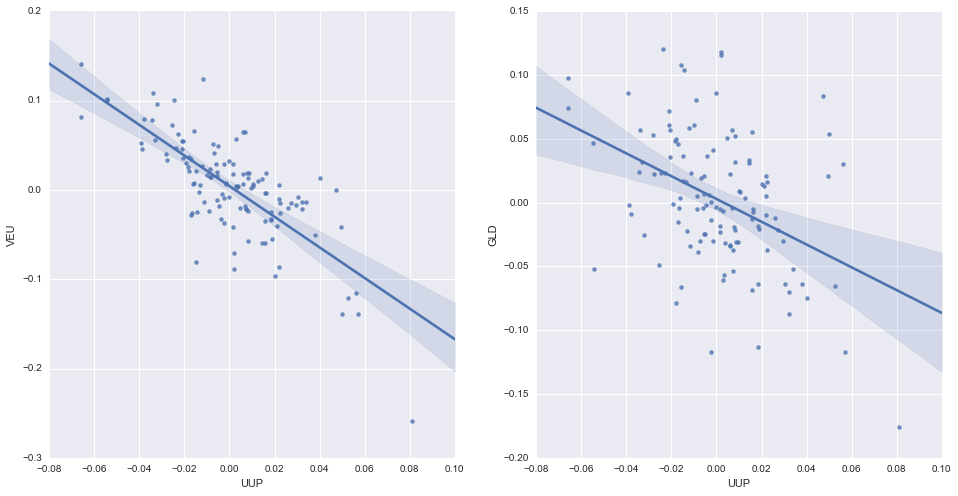

In [14]:
plt.subplot(121)
sns.regplot(x="UUP", y="VEU", data=dfm_returns)
plt.subplot(122)
sns.regplot(x="UUP", y="GLD", data=dfm_returns);

## 5.  Cómo evoluciona esta relación a lo largo del tiempo

In [15]:
"""ver notebook rolling beta"""
def calc_stats(df):
    '''
        Variable dependiente 1 columna
        variable independiente 2 columna
    '''
    X = sm.add_constant(df.iloc[:,1])
    model = sm.OLS(df.iloc[:,0],X).fit()

    beta = model.params["UUP"]
    alpha = model.params["const"]
    r2 = model.rsquared
    return beta, alpha, r2

def rolling_stats(df, window=250):
    #     dataframe to hold the results
    res = pd.DataFrame(index=df.index)

    for i in range(0,len(df.index)):

        if len(df) - i >= window:
            # break the df into smaller chunks
            chunk = df.iloc[i:window+i,:]
            # calc_stats is a function created from the code above,
            
            beta,alpha,r2 = calc_stats(chunk)
            res.set_value(chunk.tail(1).index[0],"beta",beta)
            res.set_value(chunk.tail(1).index[0],"alpha",alpha)
            res.set_value(chunk.tail(1).index[0],"r2",r2)
            # print "%s beta: %.4f \t alpha: %.4f" % (chunk.tail(1).index[0],b,a)
    res = res.dropna()
    return res

In [16]:
# Veo con EEM
dftest= dfm_returns[['EEM','UUP']]
df_rolling = rolling_stats(dftest, window= 24)

In [17]:
f= calc_stats(dftest)
f

(-1.93060488165321, 0.0037409869061494684, 0.5345817030253694)

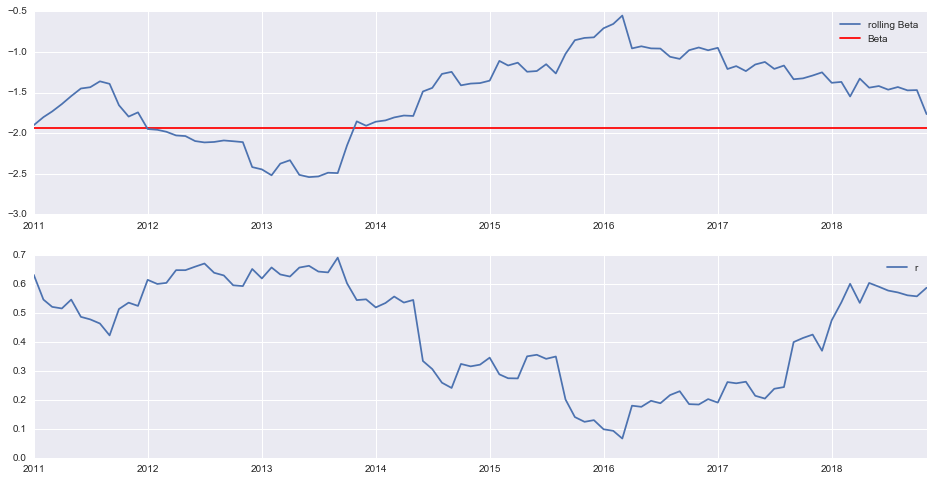

In [18]:
fig, axes = plt.subplots(nrows=2, ncols = 1)

axes[0].plot(df_rolling[["beta"]])
axes[0].hlines(calc_stats(dftest)[0],start,end,color= 'r')
axes[0].legend(['rolling Beta','Beta'], loc = 0)
axes[0].set_xlim(["2011-1-01", "2018-11-01"])

axes[1].plot(df_rolling[["r2"]],label=r"$R^2$")
axes[1].legend('r2',loc = 0)
axes[1].set_xlim(["2011-1-01", "2018-11-01"]);